In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from sklearn import linear_model
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 22.3.4 Pairs Trading in Practice: Gold vs. Gold Miners

In this coding example, we provide a basic structure for implementing a pairs trading strategy using Gold vs. Gold Miners as an example.

we run a linear regression on the price of the two assets, compute coef as hedge ratio, and check for stationarity of the spread using the augmented Dickey-Fuller test. We then iterate through the history and trade the spread when a specified z-score threshold is breached.

In [ ]:
def pairs_trade(series1, series2, lookWindow, tradeThreshold, exitThreshold=0.0):
    """
    series1 and series2: pandas Series (preferred) with same DatetimeIndex
    lookWindow (int): rolling window for z-score of spread
    tradeThreshold (float): enter/add when |z| > tradeThreshold
    exitThreshold (float): exit/flatten when |z| <= exitThreshold (0.0 means exit when z crosses the mean)
    """

    s1 = pd.Series(series1).astype(float)
    s2 = pd.Series(series2).astype(float)
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(s1.values.reshape(-1, 1), s2.values.reshape(-1, 1))
    beta = float(regr.coef_.ravel()[0])

    # augmented Dickey-Fuller test
    spread = beta * s1 - s2
    adf, pvalue, *_ = adfuller(spread)
    print(f"\nStationary Test Result: ADF={adf:.4f}; pvalue={pvalue:.2%}")

    rollSpreadMean = spread.rolling(lookWindow).mean()
    rollSpreadStd = spread.rolling(lookWindow).std()
    z = (spread - rollSpreadMean) / rollSpreadStd

    cash = 0
    pos_x = 0
    pos_y = 0
    equity = np.zeros(len(spread))

    for t in range(len(spread)):
        zt = z.iat[t]
        if np.isnan(zt):
            continue

        px = s1.iat[t]
        py = s2.iat[t]

        # exit rule
        if (pos_x != 0 or pos_y != 0) and (abs(zt) <= exitThreshold):
            cash += pos_x * px + pos_y * py
            pos_x, pos_y = 0.0, 0.0

        # entry/add rules
        if zt < -tradeThreshold:
            # long spread: long X, short beta*Y
            dpos_x = 1.0
            dpos_y = -beta
            pos_x += dpos_x
            pos_y += dpos_y
            cash += -(dpos_x * px + dpos_y * py)

        elif zt > tradeThreshold:
            # short spread: short X, long beta*Y
            dpos_x = -1.0
            dpos_y = beta
            pos_x += dpos_x
            pos_y += dpos_y
            cash += -(dpos_x * px + dpos_y * py)

        # mark-to-market equity each day
        equity[t] = cash + pos_x * px + pos_y * py

    # force liquidation at end
    if pos_x != 0 or pos_y != 0:
        cash += pos_x * s1.iat[-1] + pos_y * s2.iat[-1]
        pos_x, pos_y = 0.0, 0.0
        equity[-1] = cash

    cum_pnl = pd.Series(equity, index=spread.index).ffill()

    return cash, cum_pnl, z

In [ ]:
# example
df_px = yf.download(['GLD', 'GDX'], start='2010-01-01', end='2020-12-31', auto_adjust=False)['Adj Close']
x = df_px.iloc[:,0]
y = df_px.iloc[:,1]

lookWindow = 30
tradeThreshold = 2.0
exitThreshold = 0.2

cash, cum_pnl, z = pairs_trade(x, y, lookWindow, tradeThreshold, exitThreshold)
df = pd.concat([x, y, z, cum_pnl], axis=1, keys=['GLD', 'GDX', 'rollSpreadZ', 'cum_pnl'])
df["lb"] = -tradeThreshold
df["ub"] = tradeThreshold

[*********************100%***********************]  2 of 2 completed



Stationary Test Result: ADF=-1.3495; pvalue=60.62%


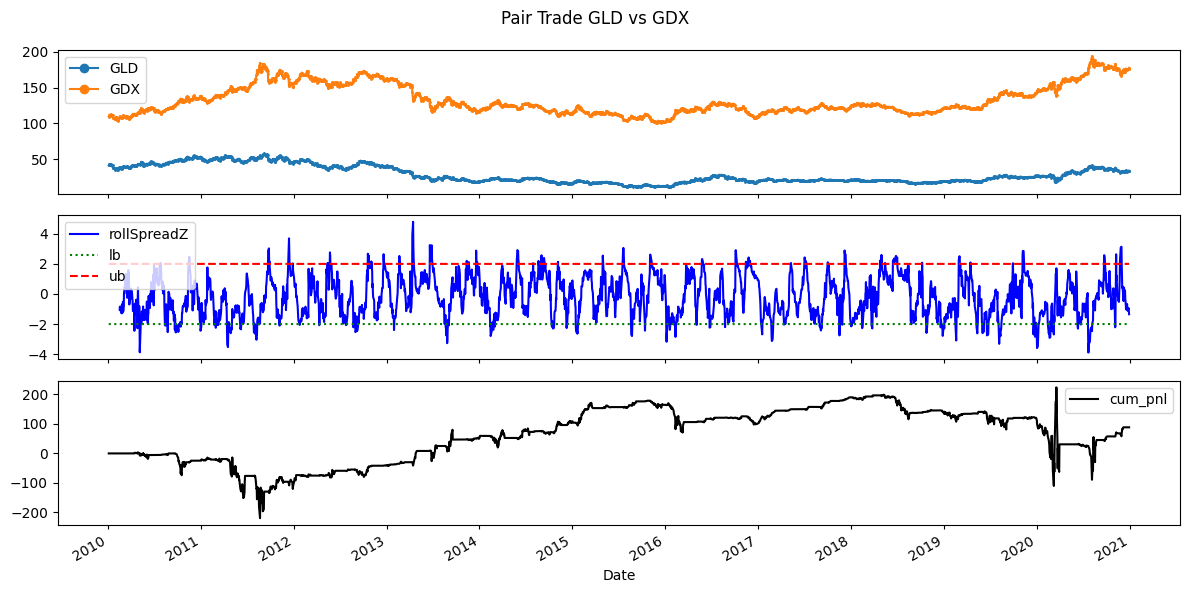

In [ ]:
# visualization
ax = df.plot(y=['GLD', 'GDX', 'rollSpreadZ', 'lb', 'ub', 'cum_pnl'], figsize=(12, 6),
        subplots=[('GLD', 'GDX'), ('rollSpreadZ', 'lb', 'ub'), ('cum_pnl', )],
        title=f"Pair Trade GLD vs GDX", style=['-o', '-o', 'b-', 'g:', 'r--', 'k-'])
for a in ax:
    for line in a.get_lines():
        line.set_markersize(1)
    a.xaxis.set_major_locator(mdates.YearLocator(base=1))
    a.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    a.minorticks_off()
    a.tick_params(axis='x', which='major', length=3)
    a.tick_params(axis='x', which='minor', length=0)

plt.tight_layout()

### 22.3.7 PCA Decomposition in Practice: How Many Principal Components Explain the S&P 500?

In this coding example, we revisit PCA implementation using `NumPy`'s built-in `linalg.eig` function on 27 large-cap stocks:

In [ ]:
def pcaAnalysis(stockReturns):
    """
    stockReturns: Pandas DataFrame of stock returns
    """
    corrMat = stockReturns.corr()
    eigenvalues, eigenvectors = np.linalg.eig(corrMat)
    explainedVarianceRatio = eigenvalues / np.sum(eigenvalues)
    singularvalues = np.sqrt((corrMat.shape[0] - 1) * eigenvalues)
    return eigenvalues, eigenvectors, explainedVarianceRatio, singularvalues

In [ ]:
# example
tickers = [
    "AAPL","MSFT","GOOGL","META","NVDA",     # Tech
    "JPM","BAC","GS","WFC",                  # Financials
    "XOM","CVX",                             # Energy
    "JNJ","PFE","UNH",                       # Health Care
    "PG","KO","PEP","WMT","COST",            # Staples
    "CAT","HON","GE","UPS",                  # Industrials
    "AMZN","TSLA","HD","MCD",                # Discretionary
]
df_px = yf.download(tickers, start='2014-03-01', end='2024-03-01', auto_adjust=False)['Adj Close']
eigenvalues, eigenvectors, explainedVarianceRatio, singularvalues = pcaAnalysis(df_px)
n = 20    # plot top 20 PC only

[*********************100%***********************]  27 of 27 completed


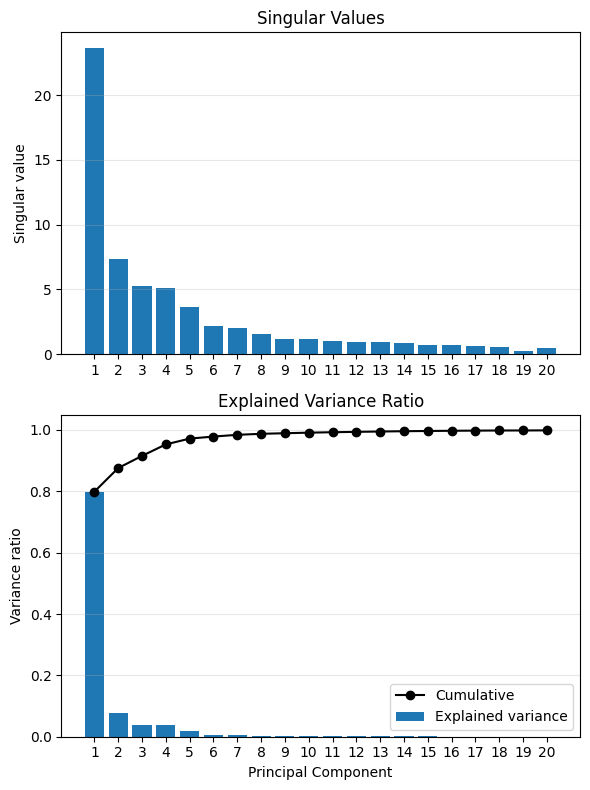

In [ ]:
# visualization
pc_idx = np.arange(1, n + 1)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

# singular values
axes[0].bar(pc_idx, singularvalues[:n])
axes[0].set_title("Singular Values")
axes[0].set_ylabel("Singular value")
axes[0].set_xticks(pc_idx)
axes[0].set_xticklabels(pc_idx)
axes[0].grid(True, axis="y", alpha=0.3)

#explained variance
axes[1].bar(pc_idx, explainedVarianceRatio[:n], label="Explained variance")
axes[1].plot(
    pc_idx,
    np.cumsum(explainedVarianceRatio[:n]),
    color="black",
    marker="o",
    label="Cumulative"
)
axes[1].set_title("Explained Variance Ratio")
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Variance ratio")
axes[1].set_xticks(pc_idx)
axes[1].set_xticklabels(pc_idx)
axes[1].legend()
axes[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### 22.3.9 Momentum in Practice: Country ETFs

In this coding example, we show how to implement a simple momentum signal on five country ETFs:


In [ ]:
def momentumStrategy(monthlyPrices, n):
    """
    monthlyPrices (pandas dataframe): dataframe of end of month prices for stocks
    n (int): the number of top stocks to buy/ bottom stocks to sell
    """

    nStocks = len(monthlyPrices.columns)
    monthlyReturns = monthlyPrices.pct_change(1)
    annualReturns = monthlyPrices.pct_change(12)

    # computing the signal as [the previous twelve-month return] minus [the last one month's return]
    momentumSignal = (annualReturns - monthlyReturns).dropna()
    # ranking in each row in descending order of signal
    rankedSignal = momentumSignal.rank(axis = 1, ascending = False)
    # names of the stocks that are ranked in the top n
    longs = rankedSignal.apply(lambda x: x.index[x <= n].tolist(),axis = 1)
    longs.name = 'long'
    # names of the stocks that are ranked in the bottom n
    shorts = rankedSignal.apply(lambda x: x.index[x  > nStocks - n ].tolist(),axis = 1)
    shorts.name = 'short'
    # putting longs and shorts into a dataframe
    longShortDf = pd.concat([longs, shorts], axis = 1)

    return longShortDf

In [ ]:
def backtestStrategy(prices, longShortDf, spy_prices):
    """
    prices: DataFrame of asset prices (index = dates, columns = tickers)
    longShortDf: DataFrame indexed by dates with columns ['long', 'short']
                where each entry is a list (or iterable) of tickers
    spy_prices: Series (or 1-col DataFrame) of SPY prices with the same date index convention
    """

    # forward returns (next-period return)
    fwMonthlyReturns = prices.pct_change().shift(-1)

    # SPY forward returns
    if isinstance(spy_prices, pd.DataFrame):
        if spy_prices.shape[1] != 1:
            raise ValueError("spy_prices DataFrame must have exactly 1 column (SPY).")
        spy_prices = spy_prices.iloc[:, 0]
    spyFwReturns = spy_prices.pct_change().shift(-1)

    # drop last row to avoid forward-return edge
    longShortDf = longShortDf.iloc[:-1]

    # align dates
    common_idx = longShortDf.index.intersection(fwMonthlyReturns.index).intersection(spyFwReturns.index)
    longShortDf = longShortDf.loc[common_idx]
    fwMonthlyReturns = fwMonthlyReturns.loc[common_idx]
    spyFwReturns = spyFwReturns.loc[common_idx]

    portfolioReturns = []
    benchmarkReturns = []

    for date, row in longShortDf.iterrows():
        longStocks = row["long"]
        shortStocks = row["short"]

        # mean long and short legs (equal-weight within each leg)
        longReturn = fwMonthlyReturns.loc[date, longStocks].mean()
        shortReturn = -fwMonthlyReturns.loc[date, shortStocks].mean()

        # equal weight long and short legs
        portfolioReturn = (longReturn + shortReturn) / 2.0

        # benchmark: SPY buy-and-hold (next-period return)
        benchmarkReturn = spyFwReturns.loc[date]

        portfolioReturns.append(portfolioReturn)
        benchmarkReturns.append(benchmarkReturn)

    portfolioReturns = pd.Series(portfolioReturns, index=longShortDf.index, name="Portfolio")
    benchmarkReturns = pd.Series(benchmarkReturns, index=longShortDf.index, name="Benchmark")

    cumulativeReturns = (1 + portfolioReturns).cumprod()
    benchmarkCumulativeReturns = (1 + benchmarkReturns).cumprod()

    # move forward to backward
    result = pd.concat([cumulativeReturns, benchmarkCumulativeReturns], axis=1).shift(1)
    result = result.fillna(1.0)

    return result

In [ ]:
# example
tickers = ['EWJ', 'EWC', 'EWG', 'EWU', 'EWA']
df_port = yf.download(tickers, start='2013-01-01', end='2021-12-31', auto_adjust=False)['Adj Close']
df_spy = yf.download('SPY', start='2013-01-01', end='2021-12-31', auto_adjust=False)['Adj Close']
df_port = df_port.resample('ME').last()           # resample to month end prices
df_spy = df_spy.resample('ME').last()

# generate long/short signals
longShortDf = momentumStrategy(df_port, 2)
# backtest
strategyReturns = backtestStrategy(df_port, longShortDf, df_spy)

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


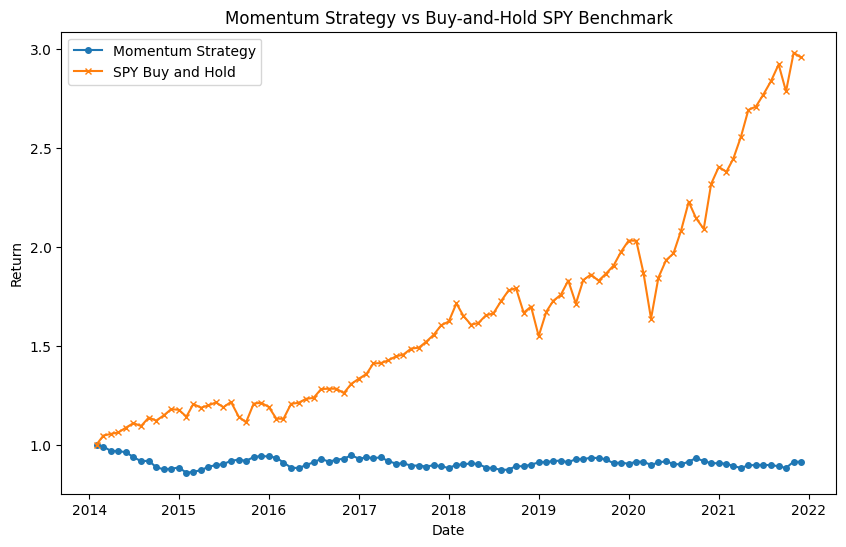

In [ ]:
# visualization
plt.figure(figsize=(10, 6))
plt.plot(strategyReturns.iloc[:, 0], label="Momentum Strategy", marker="o", markersize=4)
plt.plot(strategyReturns.iloc[:, 1], label="SPY Buy and Hold", marker="x", markersize=4)
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.title('Momentum Strategy vs Buy-and-Hold SPY Benchmark')
plt.show()

### 22.4.3 Options Strategy in Practice: Covered Calls on NASDAQ

Below we provide a coding example of a simplified options back-test for covered calls. A covered call is defined by a long position in the underlying asset and a corresponding short position in a out-of-the-money call option, therefore selling the upside potential but collecting an overwriting premium.  

We use the Black-Scholes model to calculate the call option price of QQQ based on the implied volatility given by VIX. For each month end, we hold the SPY and sell a call option at the strike price 5% higher than the current price. We compare the performance of the strategy against simply buying and holding SPY.

In [ ]:
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes option price for a European call.

    Args:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity (in years)
        r (float): Risk-free interest rate (annual)
        sigma (float): Volatility of the underlying stock (annual)

    Returns:
        call_price (float): Price of the call option
    """

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return call_price


def covered_call_backtest(df):
    """Backtest a covered call strategy.

    Args:
        df(pd.DataFrame): A monthly sampled pd.DataFrame with columns:
            "S": underlying asset's price;
            "sigma": annualized volatility of the underlying asset;
    Returns:
        pd.DataFrame
    """

    df["K"] = df["S"] * 1.05     # strike price = 5% higher than the underlying
    df["T"] = 1 / 12             # time to maturity = 1 month
    df["r"] = 0.01               # risk-free rate = 1%
    df["call_price"] = black_scholes_call(df["S"], df["K"], df["T"], df["r"], df["sigma"])

    df["call_payoff"] = np.maximum(df["S"] - df["K"].shift(1), 0)
    df["buy_and_hold_pnl"] = df["S"] - df["S"].shift(1)
    df["covered_call_pnl"] = df["buy_and_hold_pnl"] - (df["call_payoff"] - df["call_price"])      # long asset, short call
    df["buy_and_hold_cum_pnl"] = df["buy_and_hold_pnl"].cumsum()
    df["covered_call_cum_pnl"] = df["covered_call_pnl"].cumsum()
    df["outperformance"] = df["covered_call_pnl"] - df["buy_and_hold_pnl"]       # outperformance = Covered-Call - Buy-and-Hold

    return df

In [ ]:
# example
df_px = yf.download(['QQQ','^VIX'], start='2010-01-01', end='2021-12-31', auto_adjust=False)['Adj Close']
df_px = df_px.resample('ME').last()         # resample to month end prices
df_px['sigma'] = df_px['^VIX'] / 100
df_px = df_px.drop(columns=['^VIX']).rename(columns={'QQQ':'S'})
res = covered_call_backtest(df_px)

[*********************100%***********************]  2 of 2 completed


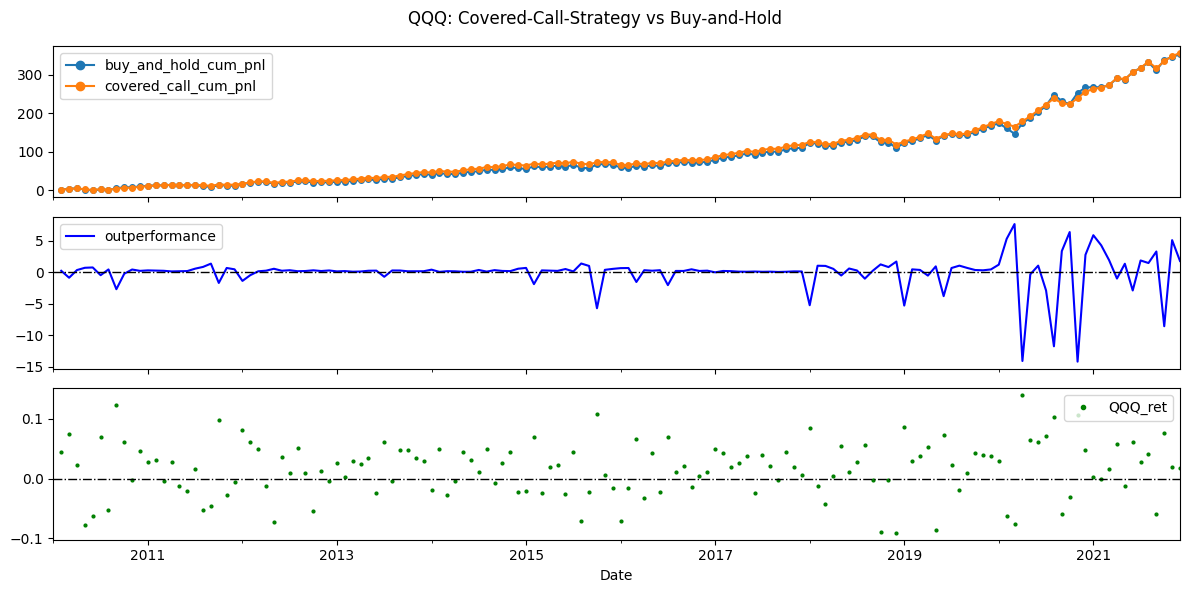

In [ ]:
# visualization
res['QQQ_ret'] = np.log(res['S']/res['S'].shift(1))
ax = res.plot(y=["buy_and_hold_cum_pnl", "covered_call_cum_pnl", "outperformance", "QQQ_ret"], figsize=(12, 6),
         subplots=[("buy_and_hold_cum_pnl", "covered_call_cum_pnl"), ("outperformance",), ("QQQ_ret",)],
         title="QQQ: Covered-Call-Strategy vs Buy-and-Hold", style=['-o', '-o', 'b-', 'g.', 'k-.', 'k-.'])
ax[1].axhline(y=0, linestyle='-.', color='black', linewidth=1)
ax[2].axhline(y=0, linestyle='-.', color='black', linewidth=1)

for a in ax:
    for line in a.get_lines():
        line.set_markersize(4)

plt.tight_layout()

<Axes: title={'center': 'Covered Call PnL Distribution'}, ylabel='Frequency'>

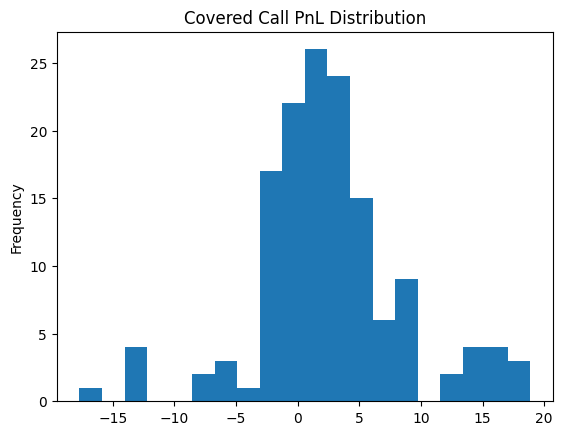

In [ ]:
res["covered_call_pnl"].plot(kind="hist", title="Covered Call PnL Distribution", bins=20)

Note: covered call strategy underperforms buy-and-hold strategy only when the market rellies on the underlying asset and thus causes the short position on the call option losses.

### 22.7 CASE STUDY: DO TREND FOLLOWING STRATEGIES PRODUCE CONVEX RETURNS?

In this example, we look at returns for AQR trend fund (AQMIX) and see if they are convex based on whether they have positive returns when SPY have large absolute changes, and whether they have negative returns when SPY tends to be prone to reversals. Then we compare it to a straddle on SPY and highlight key similarities and differences.

The readers are encouraged to further explore the relationship to some bond and commodity index using the same idea.  

In [ ]:
def compute_condition(df, threshold=0.8):
    """Compute the condition for the strategy.

    Args:
        df(pd.DataFrame): A monthly sampled pd.DataFrame with columns:
            "idx_returns": criteria index's monthly returns;
        threshold(float): threshold for the condition "large"
    Returns:
        pd.DataFrame with columns:
            "large_move": 1 if large move, 0 if not;
            "reversal": 1 if reversal, 0 if not;
    """

    df["_idx_abs_returns"] = df["idx_returns"].abs()
    df["_idx_abs_returns_cutoff"] = df["_idx_abs_returns"].quantile(threshold)

    # define large moves as abs_returns larger than the quantile
    df["large_move"] = df["_idx_abs_returns"] >= df["_idx_abs_returns_cutoff"]

    # defined reversals as returns changing signs, and either abs_returns(t) or abs_returns(t-1) larger than the quantile
    df["reversal"] = (df["idx_returns"] * df["idx_returns"].shift(1) < 0) & (
        (df["_idx_abs_returns"] >= df["_idx_abs_returns_cutoff"]) | (df["_idx_abs_returns"].shift(1) >= df["_idx_abs_returns_cutoff"])
    )
    df.drop(columns=df.columns[df.columns.str.startswith("_")])  # clean up

    return df

In [ ]:
# example
df_px = yf.download(['AQMIX','SPY','^VIX'], start='2020-01-01', end='2025-01-01', auto_adjust=False)['Adj Close']
df_px = df_px.resample('ME').last()                   # resample to month end prices
df_rets = np.log(df_px/df_px.shift(1)).dropna()       # monthly returns

condition = compute_condition(df_rets[["SPY"]].rename(columns={"SPY": "idx_returns"}), threshold=0.8)
df = pd.concat([df_rets, condition[["large_move", "reversal"]]], axis=1)

[*********************100%***********************]  3 of 3 completed


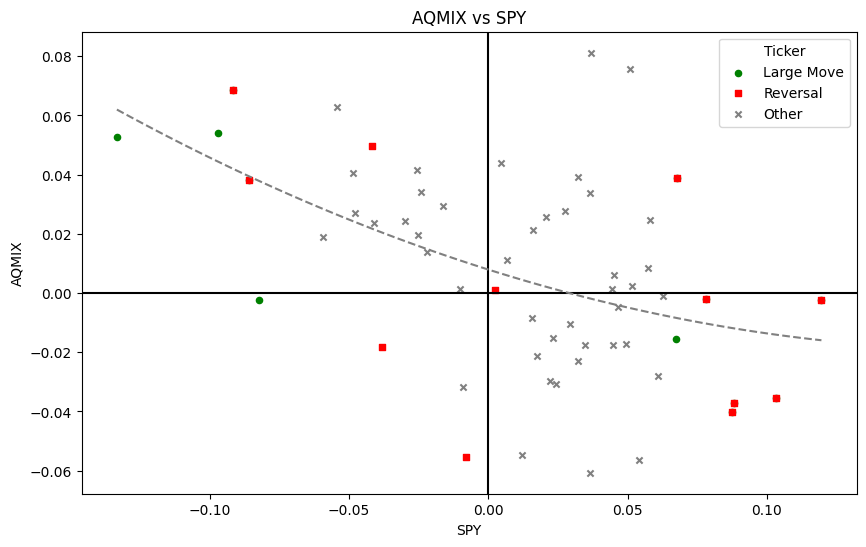

In [ ]:
# visualization
df["style"] = np.where(
    df["large_move"], "o", np.where(         # 'o' for large move
        df["reversal"], "s", "x"             # 's' for reversal, 'x' for other
    )
)

fig, ax = plt.subplots(figsize=(10, 6))
df[df["large_move"]].plot.scatter(x="SPY", y="AQMIX", ax=ax, marker="o", color="green", label="Large Move")
df[df["reversal"]].plot.scatter(x="SPY", y="AQMIX", ax=ax, marker="s", color="red", label="Reversal")
df[~df["large_move"] & ~df["reversal"]].plot.scatter(x="SPY", y="AQMIX", ax=ax, marker="x", color="gray", label="Other")

ax.axhline(0, color='black', linestyle='-')
ax.axvline(0, color='black', linestyle='-')
coef = np.polyfit(df["SPY"], df["AQMIX"], 2)
x = np.linspace(df["SPY"].min(), df["SPY"].max(), 100)
y = coef[0] * x ** 2 + coef[1] * x + coef[2]
ax.plot(x, y, color="gray", linestyle="--")
plt.title("AQMIX vs SPY")
plt.show()

In [ ]:
print(f"AQMIX Avg Returns During Large Move: {df.loc[df["large_move"], "AQMIX"].mean():.2%} vs Avg Returns: {df["AQMIX"].mean():.2%}")
print(f"AQMIX Avg Returns During Reversal: {df.loc[df["reversal"], "AQMIX"].mean():.2%} vs Avg Returns: {df["AQMIX"].mean():.2%}")

AQMIX Avg Returns During Large Move: 0.98% vs Avg Returns: 0.69%
AQMIX Avg Returns During Reversal: 0.05% vs Avg Returns: 0.69%


We can see that, on average, AQMIX outperforms during large moves and underperforms during reversals. And the returns exhibit a convex shape. Now, we consider a straddle strategy on SPY:

In [ ]:
def black_scholes_straddle(S, K, T, r, sigma):
    """Calculate the straddle price using Black-Scholes

    Args:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity (in years)
        r (float): Risk-free interest rate (annual)
        sigma (float): Volatility of the underlying stock (annual)

    Returns:
        price (float): Price of the straddle
    """

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    straddle = call + put

    return straddle


def straddle_backtest(df):
    """Backtest a straddle strategy

    Args:
        df (pd.DataFrame): A dataframe containing the following columns:
            - S: Current stock price
            - K: Strike price
            - T: Time to maturity (in years)
            - r: Risk-free interest rate (annual)
            - sigma: Volatility of the underlying stock (annual)
    Returns:
        pd.DataFrame with columns:
            - straddle_price: Price of the straddle
            - straddle_pnl: PNL of the straddle
            - straddle_ret: Returns of the straddle strategy
    """
    df["straddle_price"] = black_scholes_straddle(df["S"], df["K"], df["T"], df["r"], df["sigma"])
    df["straddle_pnl"] = (df["S"] - df["K"].shift(1)).abs() - df["straddle_price"].shift(1)
    df["straddle_ret"] = df["straddle_pnl"] / (df["straddle_price"].shift(1))

    return df

In [ ]:
# example
df = df_px.copy()
df["S"] = df["SPY"]
df["K"] = df["SPY"]                  # at-the-money
df["T"] = 1/12                       # time to maturity = 1 month
df["r"] = 0.01                       # risk-free rate = 1%
df["sigma"] = df_px["^VIX"] / 100    # annualized implied volatility

df = straddle_backtest(df)
df["SPY_ret"] = np.log(df['SPY']/df['SPY'].shift(1))
df.dropna(inplace=True)

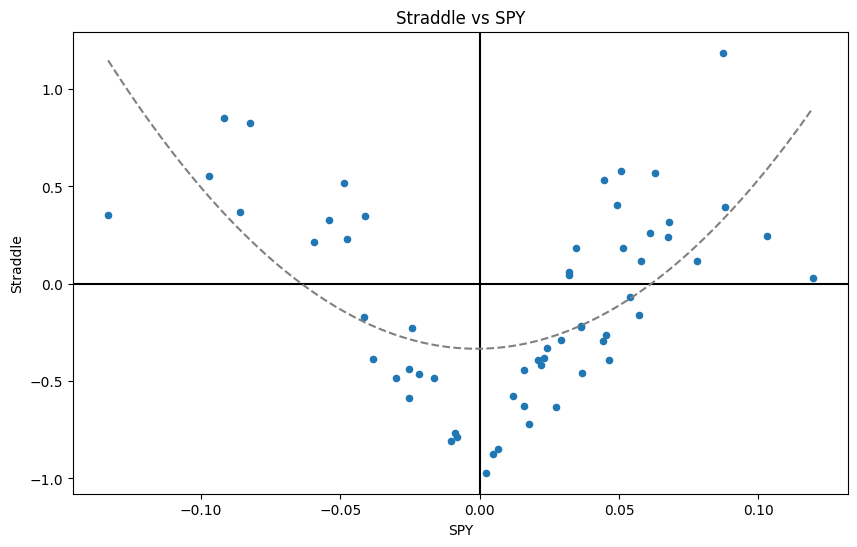

In [ ]:
# visualization
ax = df.plot.scatter(x="SPY_ret", y="straddle_ret", figsize=(10, 6), title="Straddle vs SPY")
ax.axhline(0, color='black', linestyle='-')
ax.axvline(0, color='black', linestyle='-')
coef = np.polyfit(df["SPY_ret"], df["straddle_ret"], 2)
x = np.linspace(df["SPY_ret"].min(), df["SPY_ret"].max(), 100)
y = coef[0] * x ** 2 + coef[1] * x + coef[2]
ax.plot(x, y, color="gray", linestyle="--")
plt.ylabel('Straddle')
plt.xlabel('SPY')
plt.show()

Similar to AQMIX, the straddle strategy exhibits a convex shape and outperforms when SPY has a large move and underperforms when SPY is calm. However, unlike a trending following strategy, the straddle strategy doesn't care about whether the trend of SPY continues or reverses.